# Exploring Transformer Architectures

<a target="_blank" href="https://colab.research.google.com/github/raghavbali/llm_workshop/blob/main/module_01/03_explore_transformers.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


## The RNN Limitation
The RNN layer (LSTM, or GRU, etc.) takes in a context window of a defined size as input and encodes all of it into a single vector. This bottleneck vector needs to capture a lot of information in itself before the decoding stage can use it to start generating the next token. To enhance performance of sequence to sequence tasks a typical Encoder-Decoder architecture is the go-to choice.

<img src="../assets/02_encoder_decoder_notebook_3.png">

Let us consider the case of **Machine Translation**, i.e. translation of English to Spanish (or any other language).

In a typical __Encoder-Decoder__ architecture, the Encoder takes in the input text in English as input and prepares a condensed vector representation of the whole input. Typically termed as bottleneck features. The Decoder then uses these features to generate the translated text in Spanish.

While this architecture and its variants worked wonders, they had issues. Issues such as inability handle longer input sequences, cases where there is not a one to one mapping between input vs output language and so on.

To handle these issues, __Vasvani et. al.__ in their now famouly titled paper __Attention Is All You Need__ build up on the concepts of attention. The main highlight of this work was the Transformer architecture. Transformers were shown to present state of the art results on multiple benchmarks without using any recurrence or convolutional components.

## Transformers
- The transformer architecture was presented in the seminal paper __Attention is All You Need__ by Vaswani et al. back in 2017
- A transformer is a __recurrence-__ and __convolution-free__ attention-based encoder-decoder architecture
- Introduced the concept of multi-head attention and positional encodings
- Also revolutionalised Computer Vision domain (see ViT)


<img src="../assets/02_transformer_arch_notebook_3.png">

### Positional Encoding
Positional encoding is a technique used to incorporate the position of each token in the input sequence. It provides the model with information about the token's position without relying solely on the order of tokens.
This additional aspect was required because transformers do not have the natural sequential setup of RNNs. In order to provide positional context, any encoding system should ideally have the following properties:

- It should output a unique encoding for each time-step (word’s position in a sentence)
- Distance between any two time-steps should be consistent across sentences with different lengths.
- Our model should generalize to longer sentences without any efforts. Its values should be bounded.
- It must be deterministic.

<img src="../assets/02_positional_emb_notebook_3.png">



### References
- [The Illustrated Transformer](https://jalammar.github.io/illustrated-transformer/)

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle, FancyBboxPatch
from matplotlib.patches import ConnectionPatch
import torch
import torch.nn as nn
import torch.nn.functional as F

plt.style.use(['science','no-latex'])

# =====================================
#  POSITIONAL ENCODING 
# =====================================

def positional_encoding(pos, i, d_model, is_even=True):
    """
    Method to generate positional encoding value
    :param pos: position of the input
    :param i: i-th dimension of the embedding
    :param d_model: length of the embedding vector
    :param is_even: if the position of the input is even or odd
    """
    input_val = pos / np.power(10000, (2 * i) / d_model)
    if is_even:
        return np.sin(input_val)
    else:
        return np.cos(input_val)

# Complete the positional encoding visualization
def visualize_positional_encoding():
    """Complete visualization of positional encodings"""
    pos = np.arange(0, 10, 0.1)
    dimensions = np.arange(0, 512)
    d_model = 512
    
    # Positional encoding for even positions
    even_pos_emb = [positional_encoding(pos, i, d_model, is_even=True) for i in dimensions]
    # Positional encoding for odd positions
    odd_pos_emb = [positional_encoding(pos, i, d_model, is_even=False) for i in dimensions]
    
    show_dim = [0, 16, 32]
    plt.figure(figsize=(15, 5))
    
    for i in dimensions:
        if i in show_dim:
            plt.plot(pos, even_pos_emb[i], label=f'sin(dim {i})', linestyle='-')
            plt.plot(pos, odd_pos_emb[i], label=f'cos(dim {i})', linestyle='--')
    
    plt.axvline(2, linestyle='--', c='black', alpha=0.5)
    plt.title("Positional Encodings: Sin/Cos Waves at Different Dimensions")
    plt.xlabel("Input Positions")
    plt.ylabel("Encoding Value")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Additional heatmap visualization
    plt.figure(figsize=(12, 8))
    pos_matrix = np.zeros((50, 128))  # 50 positions, 128 dimensions
    
    for pos_idx in range(50):
        for dim in range(128):
            if dim % 2 == 0:
                pos_matrix[pos_idx, dim] = positional_encoding(pos_idx, dim//2, 128, is_even=True)
            else:
                pos_matrix[pos_idx, dim] = positional_encoding(pos_idx, dim//2, 128, is_even=False)
    
    plt.imshow(pos_matrix, cmap='RdBu', aspect='auto')
    plt.colorbar(label='Encoding Value')
    plt.title('Positional Encoding Heatmap (50 positions × 128 dimensions)')
    plt.xlabel('Embedding Dimension')
    plt.ylabel('Position')
    plt.show()

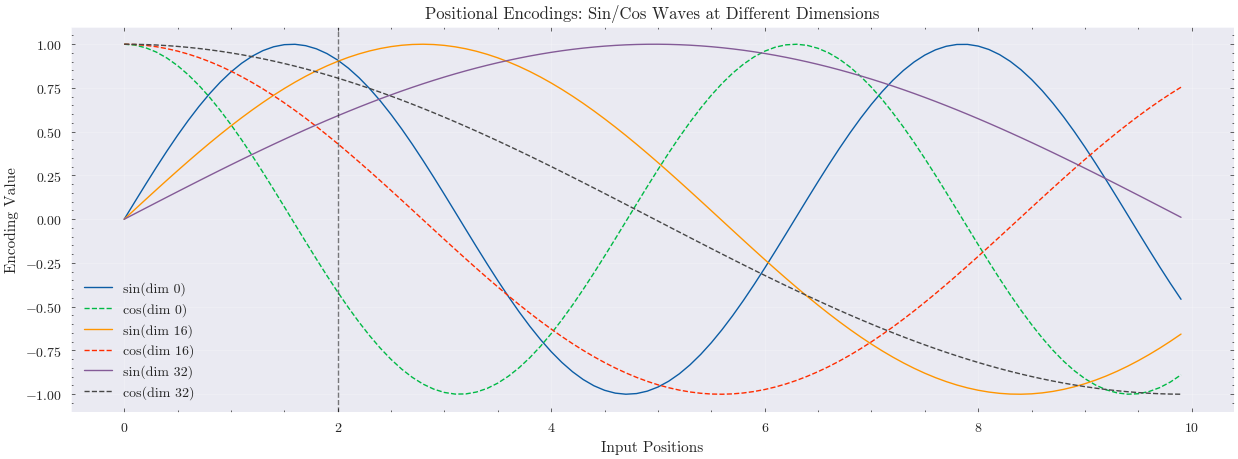

/Users/raghavbali/.pyenv/versions/3.11.9/envs/datahack/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 215 (\N{MULTIPLICATION SIGN}) missing from font(s) cmr10.
  fig.canvas.print_figure(bytes_io, **kw)


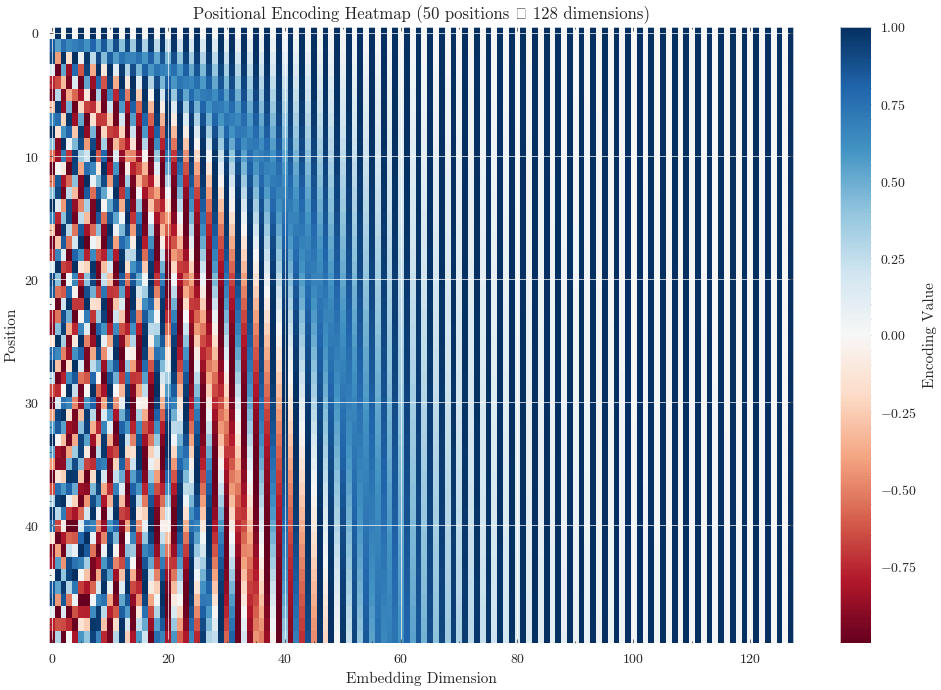

In [19]:
visualize_positional_encoding()

## Attention is All you Need ⚠️


### Attention to the Rescue
Attention is one of the most powerful concepts in the deep learning space that really changed the game. The core idea behind the attention mechanism is to make use of all interim hidden states of the RNN to decide which one to focus upon before it is used by the decoding stage. 

### Contextual Embeddings
The [TagLM architecture by Peters et al. in 2017](https://arxiv.org/abs/1705.00108) was one of the first works that provided an insight into how we could combine __pre-trained word embeddings__ with a __pre-trained neural language model__ to generate __context-aware embeddings__ for downstream NLP tasks.

The big breakthrough that changed the NLP landscape came in the form of __ELMo, or Embeddings from Language Models__. The ELMo architecture was presented by Peters et al. in their work titled [__Deep Contextualized Word Representations in 2018__](https://arxiv.org/abs/1802.05365). Without going into too much detail, the main highlights of the ELMo architecture were:

- The model used a bi-LSTM-based language model.
- Character CNNs were used to generate embeddings, in place of pre-trained word vectors, which made use of huge 4096 LSTM units but transformed into smaller 512-sized vectors using feedforward layers.
- The main innovation was to make use of all the hidden bi-LSTM layers for generating input representation. Unlike previous works, where only the final LSTM layer was used to fetch the representation of the input, this work took a weighted average of all the hidden layers' hidden states. This helped the model learn contextual word embeddings where each layer contributed to things like syntax and semantics.

### Self-Attention
- Self-attention was proposed by Cheng et al. in their paper titled Long Short-Term Memory Networks for Machine Reading in 2016
- Self-attention enables a model to learn the correlation between the current token (character or word or sentence, etc.) and its context window. In other words, it is an attention mechanism that relates different positions of a given sequence so as to generate a representation of the same sequence

In [20]:
# =====================================
# ATTENTION MECHANISM 
# =====================================

def attention_mechanism(query, key, value, mask=None, temperature=1.0):
    """
    Scaled Dot-Product Attention
    :param query: Query matrix [batch_size, seq_len, d_k]
    :param key: Key matrix [batch_size, seq_len, d_k]
    :param value: Value matrix [batch_size, seq_len, d_v]
    :param mask: Optional mask to prevent attention to certain positions
    :param temperature: Temperature for softmax (default=sqrt(d_k))
    """
    d_k = query.shape[-1]
    
    # Compute attention scores: Q * K^T
    scores = np.matmul(query, np.transpose(key, (0, 2, 1))) / np.sqrt(d_k * temperature)
    
    # Apply mask if provided
    if mask is not None:
        scores = np.where(mask == 0, -1e9, scores)
    
    # Apply softmax to get attention weights
    attention_weights = np.exp(scores) / np.sum(np.exp(scores), axis=-1, keepdims=True)
    
    # Apply attention weights to values
    output = np.matmul(attention_weights, value)
    
    return output, attention_weights

def visualize_attention():
    """Visualize attention mechanism with a simple example - FIXED VERSION"""
    # Create sample data
    seq_len = 6
    d_model = 8
    
    # Simple sentence: "The cat sat on the mat"
    words = ["The", "cat", "sat", "on", "the", "mat"]
    
    # Create random embeddings for demonstration
    np.random.seed(42)
    embeddings = np.random.randn(1, seq_len, d_model)
    
    # Linear transformations to get Q, K, V (simplified)
    W_q = np.random.randn(d_model, d_model) * 0.1
    W_k = np.random.randn(d_model, d_model) * 0.1
    W_v = np.random.randn(d_model, d_model) * 0.1
    
    query = np.matmul(embeddings, W_q)
    key = np.matmul(embeddings, W_k)
    value = np.matmul(embeddings, W_v)
    
    # Compute attention
    output, attention_weights = attention_mechanism(query, key, value)
    
    # Visualize attention weights
    plt.figure(figsize=(10, 8))
    plt.imshow(attention_weights[0], cmap='Blues', interpolation='nearest')
    plt.colorbar(label='Attention Weight')
    plt.title('Attention Weights Visualization')
    plt.xlabel('Key Position')
    plt.ylabel('Query Position')
    plt.xticks(range(seq_len), words)
    plt.yticks(range(seq_len), words)
    
    # Add text annotations
    for i in range(seq_len):
        for j in range(seq_len):
            plt.text(j, i, f'{attention_weights[0, i, j]:.2f}', 
                    ha='center', va='center', fontsize=10)
    
    plt.tight_layout()
    plt.show()

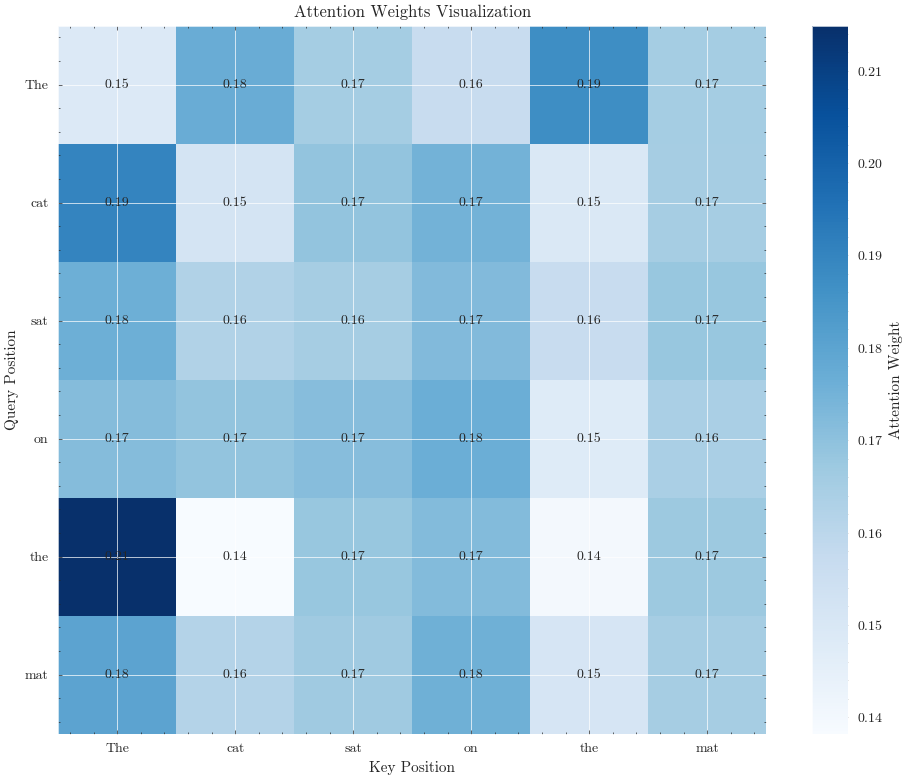

In [21]:
visualize_attention()

### Multi-head Attention
- Multi-head attention extends the self-attention mechanism by performing multiple parallel self-attention operations, each focusing on different learned linear projections of the input. Multiple attention heads allow the model to capture different types of relationships and learn more fine-grained representations (eg: grammar, context, dependency, etc.)

<img src="../assets/02_multihead_attention_notebook_3.png">

> Source: [Vasvani et. al.](https://arxiv.org/pdf/1706.03762.pdf)


### Internals of a Transformer
<img src = "../assets/02_transformer_explainer.png">
> Source: [Transformer Explainer](https://poloclub.github.io/transformer-explainer/)

In [24]:
# =====================================
#  MULTI-HEAD ATTENTION
# =====================================

class MultiHeadAttention:
    """Multi-Head Attention implementation for educational purposes"""
    
    def __init__(self, d_model, num_heads):
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        
        # Initialize weight matrices
        np.random.seed(42)
        self.W_q = np.random.randn(d_model, d_model) * 0.1
        self.W_k = np.random.randn(d_model, d_model) * 0.1
        self.W_v = np.random.randn(d_model, d_model) * 0.1
        self.W_o = np.random.randn(d_model, d_model) * 0.1
    
    def forward(self, query, key, value, mask=None):
        batch_size, seq_len, d_model = query.shape
        
        # Linear transformations
        Q = np.matmul(query, self.W_q)
        K = np.matmul(key, self.W_k)
        V = np.matmul(value, self.W_v)
        
        # Reshape for multi-head attention
        Q = Q.reshape(batch_size, seq_len, self.num_heads, self.d_k)
        K = K.reshape(batch_size, seq_len, self.num_heads, self.d_k)
        V = V.reshape(batch_size, seq_len, self.num_heads, self.d_k)
        
        # Transpose to get [batch_size, num_heads, seq_len, d_k]
        Q = np.transpose(Q, (0, 2, 1, 3))
        K = np.transpose(K, (0, 2, 1, 3))
        V = np.transpose(V, (0, 2, 1, 3))
        
        # Apply attention for each head
        attention_outputs = []
        attention_weights_all = []
        
        for head in range(self.num_heads):
            # Extract single head: [batch_size, seq_len, d_k]
            q_head = Q[:, head, :, :]
            k_head = K[:, head, :, :]
            v_head = V[:, head, :, :]
            
            output, weights = attention_mechanism(q_head, k_head, v_head, mask)
            attention_outputs.append(output)
            attention_weights_all.append(weights)
        
        # Concatenate heads
        concat_output = np.concatenate(attention_outputs, axis=-1)
        
        # Final linear transformation
        final_output = np.matmul(concat_output, self.W_o)
        
        return final_output, attention_weights_all

def visualize_multihead_attention():
    """Visualize multi-head attention mechanism"""
    # Setup
    seq_len = 6
    d_model = 64
    num_heads = 8
    
    words = ["The", "cat", "sat", "on", "the", "mat"]
    
    # Create sample input
    np.random.seed(42)
    input_embeddings = np.random.randn(1, seq_len, d_model)
    
    # Initialize multi-head attention
    mha = MultiHeadAttention(d_model, num_heads)
    
    # Forward pass
    output, attention_weights = mha.forward(input_embeddings, input_embeddings, input_embeddings)
    
    # Visualize attention weights for each head
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()
    
    for head in range(num_heads):
        im = axes[head].imshow(attention_weights[head][0], cmap='Blues', interpolation='nearest')
        axes[head].set_title(f'Head {head + 1}')
        axes[head].set_xticks(range(seq_len))
        axes[head].set_yticks(range(seq_len))
        axes[head].set_xticklabels(words, rotation=45)
        axes[head].set_yticklabels(words)
        
        # Add colorbar
        plt.colorbar(im, ax=axes[head], shrink=0.8)
    
    plt.tight_layout()
    plt.suptitle('Multi-Head Attention Weights (8 heads)', y=1.02)
    plt.show()
    
    # Show head specialization
    plt.figure(figsize=(12, 8))
    
    # Average attention weights across heads
    avg_attention = np.mean([weights[0] for weights in attention_weights], axis=0)
    
    # Show different patterns each head learns
    head_patterns = []
    for head in range(num_heads):
        pattern_strength = np.std(attention_weights[head][0])
        head_patterns.append(pattern_strength)
    
    plt.subplot(2, 2, 1)
    plt.bar(range(num_heads), head_patterns)
    plt.title('Pattern Diversity by Head')
    plt.xlabel('Head Number')
    plt.ylabel('Attention Variance')
    
    plt.subplot(2, 2, 2)
    plt.imshow(avg_attention, cmap='Blues')
    plt.colorbar(label='Average Attention')
    plt.title('Average Attention Across All Heads')
    plt.xticks(range(seq_len), words)
    plt.yticks(range(seq_len), words)
    
    plt.tight_layout()
    plt.show()

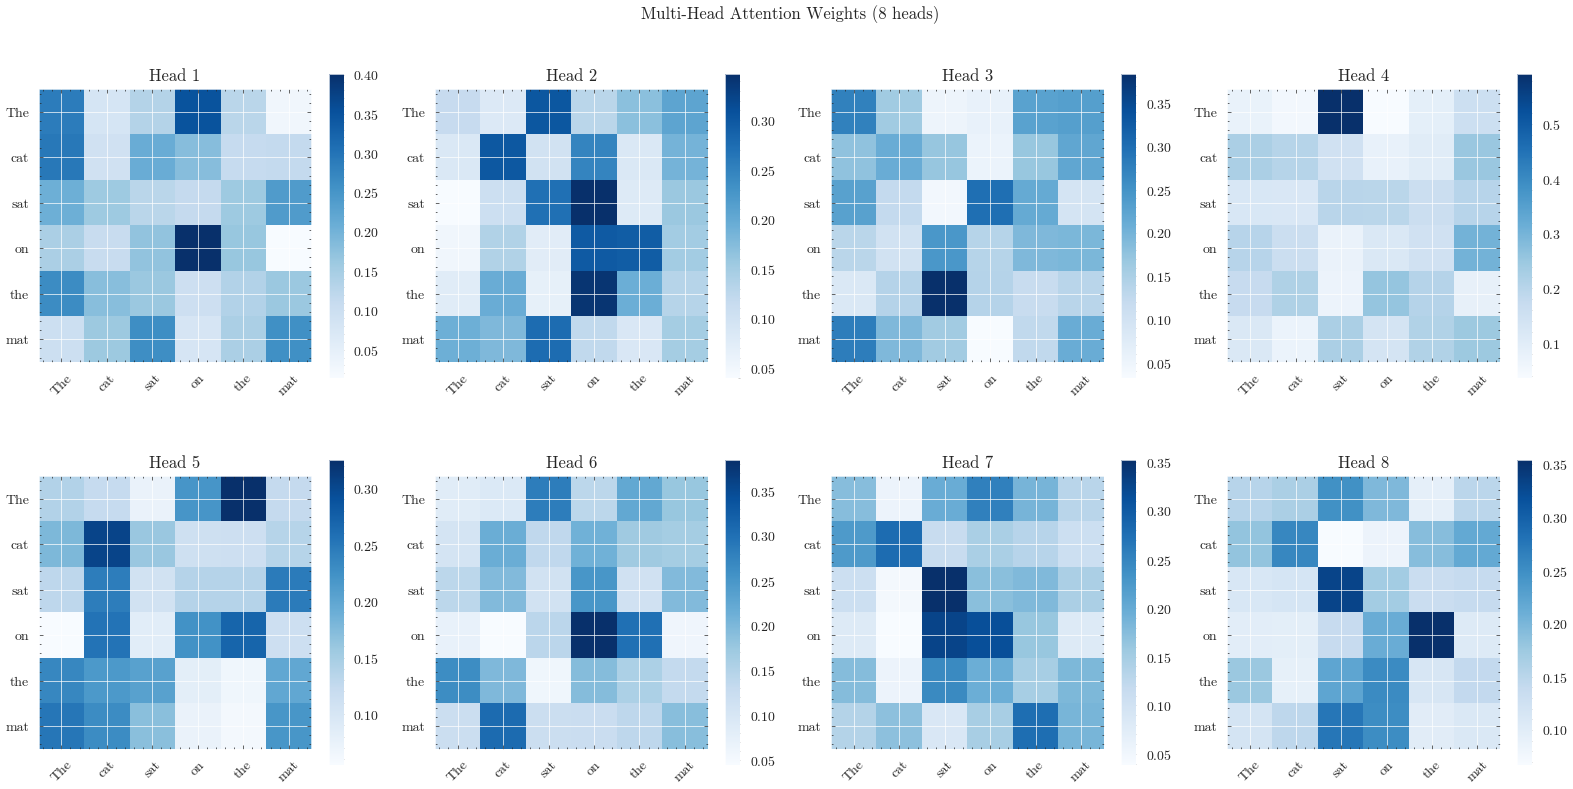

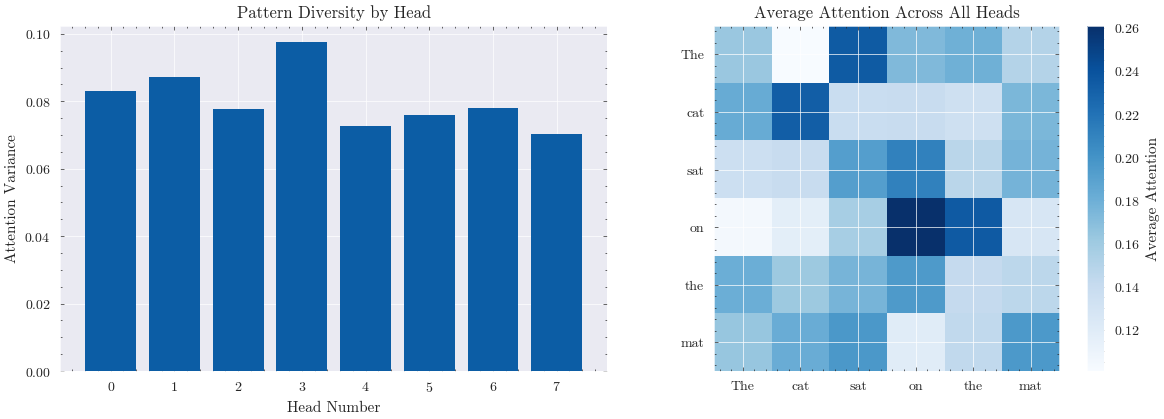

In [23]:
visualize_multihead_attention()

# Transformer Architecture Configurations: 
> Encoder-Decoder, Encoder Only and Decoder Only


<img src="../assets/02_transformer_arch.png">

> Source: Yang et al.